### Run this code with the Exp_2_WithoutObstacles.ttt Scene open

# IPC

In [2]:
from __future__ import print_function
import gym
import gym_kheperaposition
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from PIL import Image

Vmax=0.05
Wmax=math.pi/4


Kr_Prop=0.025   
K1=0.1
Kp=0.75
Ki=0.00007 
PI=3.1415 

def random_agent(steps=800, angle=0):
    episode_reward = 0
    ErrorAcumulado=0
    env = gym.make('KheperaPositionControl-v0')
    env.MaxSteps = steps
    env.radius = 0.95
    x,y = env.change_target_angle(angle)
    d, Oc = env.reset()
    #env.render()
    ISE_acumulado = 0
    IAE_acumulado = 0
    ITSE_acumulado = 0
    ITAE_acumulado = 0
    
    data = {}
    paso = []
    infoOc = []
    infoD = []
    Lineal = []
    Angular = []
    xc = []
    yc = []

    
    for e in range(steps):
        error = math.atan2(math.sin(Oc), math.cos(Oc))
        p = ((math.pi-math.fabs(error))/math.pi)
        v = min(K1*d*p, Vmax)
        if p > 0.9 and d > Kr_Prop:
            v = Vmax
        if d < Kr_Prop:
            v = 0
            w = 0
        ErrorAcumulado = error + ErrorAcumulado
        w = Kp*math.sin(Oc)+Ki*ErrorAcumulado
        Vl = (v-(w*0.1)/2)*48
        Vr = (v+(w*0.1)/2)*48
        action = [Vl, Vr]
        state, reward, done, info = env.step(action)
        d, Oc = state
        #env.render()
        #print(reward)
        print(reward, end='\r')
        sys.stdout.flush()
        
        episode_reward += reward
        x = info['xc']
        y = info['yc']
        
        paso.append(e)
        infoOc.append(float(Oc))
        infoD.append(float(d))
        Lineal.append(float(v))
        Angular.append(float(w))
        xc.append(float(x))
        yc.append(float(y))       
        
        if done:
            print('Reward of the episode is: ',episode_reward)
            break
    env.close()
   
    data={'paso' : paso,
          'Oc' : infoOc,
          'Distance' : infoD,
          'Lineal' : Lineal,
          'Angular' : Angular,
          'xc' : xc,
          'yc' : yc
    }
    
    #print(data)
    return data

def indices_rendimiento(data):   
    d, t = [np.array(data['Distance']), 0.05*np.array(data['paso'])]

    IAE = np.trapz(abs(d),t)
    ISE = np.trapz(d**2,t)
    ITAE = np.trapz(t*abs(d),t)
    ITSE = np.trapz(t*(d**2),t)
    
    return IAE,ISE,ITAE,ITSE

In [3]:
IPC_178 = random_agent(800, 178)
IPC_135 = random_agent(800, 135)
IPC_90 = random_agent(800, 45)

Connected to remote API server
Reward of the episode is:  23.858593531448093
Connected to remote API server
Reward of the episode is:  223.35777443722768
Connected to remote API server
Reward of the episode is:  316.8860447727938


# Villela

In [4]:
import gym
import gym_kheperaposition
import numpy as np
import math
import sys

Vmax=0.05
Wmax=math.pi/4
L=0.1
Kr_V_RL=0.05   # radio de seguridad

def random_agent_villela(steps=900, angle=0):
    episode_reward = 0
    env = gym.make('KheperaPositionControl-v0')
    env.MaxSteps = steps
    env.radius = 0.95
    x,y = env.change_target_angle(angle)
    state = env.reset()
    d, Oc = state
    states = [] 
    #env.render()
    ISE_acumulado = 0
    IAE_acumulado = 0
    ITSE_acumulado = 0
    ITAE_acumulado = 0
    
    data = {}
    paso = []
    infoOc = []
    infoD = []
    Lineal = []
    Angular = []
    xc = []
    yc = []
    
    for e in range(steps):
        w = Wmax*math.sin(Oc)
        if d > Kr_V_RL:
            v = Vmax
        else:
            v = d*(Vmax/Kr_V_RL)
        if d < 0.02:
            v = 0
            w = 0
        states.append([state, e])
        Vl = (v-(w*0.1)/2)*48
        Vr = (v+(w*0.1)/2)*48
        action = [Vl, Vr]
        state, reward, done, info = env.step(action)
        d, Oc = state
        
        #env.render()
        #print(reward)
        print(reward, end='\r')
        sys.stdout.flush()
        episode_reward += reward
        
        x = info['xc']
        y = info['yc']
        
        paso.append(e)
        infoOc.append(float(Oc))
        infoD.append(float(d))
        Lineal.append(float(v))
        Angular.append(float(w))
        xc.append(np.array(x))
        yc.append(np.array(y))
        
        if done:
            print('Reward of the episode is: ',episode_reward)
            break
    
    env.close()
    data={'paso' : paso,
          'Oc' : infoOc,
          'Distance' : infoD,
          'Lineal' : Lineal,
          'Angular' : Angular,
          'xc' : xc,
          'yc' : yc
    }
    #print(data)
    return data

In [5]:
Villela_178 = random_agent_villela(800, 178)
Villela_135 = random_agent_villela(800, 135)
Villela_90 = random_agent_villela(800, 45)

Connected to remote API server
Reward of the episode is:  -224.67477149018185
Connected to remote API server
Reward of the episode is:  218.16057431446185
Connected to remote API server
Reward of the episode is:  317.11672252063534


# DQN 

In [6]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# No GPU found

No GPU found


In [7]:
import numpy as np
import gym
import gym_kheperaposition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

ENV_NAME = 'KheperaPositionObstacleD-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.radius = 0.95
nb_actions = env.action_space.n
env.MaxSteps = 900
env.table = 2
env.Randomize = False
env.Movements = [[4.285,0.515],[2.4,2.4],[0.515,4.285]]

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1100000, window_length=1)
#policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=0.1, value_test=.05,
                              nb_steps=1300000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

from OwnCallbacks import TestLogger
dqn.load_weights('Weights/dqn.h5')
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(178)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
DQN_178 = pickle.load(f)
f.close()
env.close()

Connected to remote API server
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)

In [8]:
import numpy as np
import gym
import gym_kheperaposition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

ENV_NAME = 'KheperaPositionObstacleD-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.radius = 0.95
nb_actions = env.action_space.n
env.MaxSteps = 900
env.table = 2
env.Randomize = False
env.Movements = [[4.285,0.515],[2.4,2.4],[0.515,4.285]]

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1100000, window_length=1)
#policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=0.1, value_test=.05,
                              nb_steps=1300000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

from OwnCallbacks import TestLogger
dqn.load_weights('Weights/dqn.h5')
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(135)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
DQN_135 = pickle.load(f)
f.close()

env.close()

Connected to remote API server
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               6656      
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_6 (Activatio

In [9]:
import numpy as np
import gym
import gym_kheperaposition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

ENV_NAME = 'KheperaPositionObstacleD-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.radius = 0.95
nb_actions = env.action_space.n
env.MaxSteps = 900
env.table = 2
env.Randomize = False
env.Movements = [[4.285,0.515],[2.4,2.4],[0.515,4.285]]

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1100000, window_length=1)
#policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=0.1, value_test=.05,
                              nb_steps=1300000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

from OwnCallbacks import TestLogger
dqn.load_weights('Weights/dqn.h5')
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(45)
dqn.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
DQN_90 = pickle.load(f)
f.close()

env.close()

Connected to remote API server
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               6656      
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_10 (Activati

## DDPG

In [10]:
import numpy as np
import gym
import gym_kheperaposition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, BatchNormalization, Add
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import math

# Se prepara el entorno
ENV_NAME = 'KheperaPositionObstacle-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.radius = 0.95
env.Randomize = False
env.MaxSteps = 900
env.table = 2

env.Vmax=0.05
env.Wmax=math.pi/4

nb_actions = env.action_space.shape[0]
nb_observation = env.observation_space.shape[0]
max_Lin_Vel, max_Ang_Vel = env.action_space.high

# Se crean los modelos de Actor y Critic
inputs = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
out = Flatten()(inputs)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
Lin_Vel = Dense(1, activation="sigmoid")(out)
Ang_Vel = layers.Dense(1, activation="tanh")(out)
outputs = Concatenate()([Lin_Vel,Ang_Vel])

Actor = Model(inputs, outputs)
print(Actor.summary())

observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
observation_inputs = Flatten()(observation_input)
observation_inputs = Dense(512, activation="relu")(observation_inputs)

action_input = Input(shape=nb_actions, name='action_input')

concat = Concatenate()([observation_inputs, action_input])

observation_out = Dense(512, activation="relu")(concat)
observation_out = Dense(512, activation="relu")(observation_out)
state_outputs = Dense(1, activation="linear")(observation_out)

Critic = Model([observation_input, action_input], state_outputs)
print(Critic.summary())

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=Actor, critic=Critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=5000, nb_steps_warmup_actor=5000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

agent.compile(Adam(lr=.0005, clipnorm=1.), metrics=['mae'])

from OwnCallbacks import TestLogger
pesos = 'Weights/ddpg.h5'
agent.load_weights(pesos)
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(178)
agent.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
ddpg_178 = pickle.load(f)
f.close()

env.close()

Connected to remote API server
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 12)           0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 512)          6656        flatten_3[0][0]                  
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          262656      dense_12[0][0]                   
________________________________________________________

In [11]:
import numpy as np
import gym
import gym_kheperaposition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, BatchNormalization, Add
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import math

# Se prepara el entorno
ENV_NAME = 'KheperaPositionObstacle-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.radius = 0.95
env.Randomize = False
env.MaxSteps = 900
env.table = 2

env.Vmax=0.05
env.Wmax=math.pi/4

nb_actions = env.action_space.shape[0]
nb_observation = env.observation_space.shape[0]
max_Lin_Vel, max_Ang_Vel = env.action_space.high

# Se crean los modelos de Actor y Critic
inputs = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
out = Flatten()(inputs)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
Lin_Vel = Dense(1, activation="sigmoid")(out)
Ang_Vel = layers.Dense(1, activation="tanh")(out)
outputs = Concatenate()([Lin_Vel,Ang_Vel])

Actor = Model(inputs, outputs)
print(Actor.summary())

observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
observation_inputs = Flatten()(observation_input)
observation_inputs = Dense(512, activation="relu")(observation_inputs)

action_input = Input(shape=nb_actions, name='action_input')

concat = Concatenate()([observation_inputs, action_input])

observation_out = Dense(512, activation="relu")(concat)
observation_out = Dense(512, activation="relu")(observation_out)
state_outputs = Dense(1, activation="linear")(observation_out)

Critic = Model([observation_input, action_input], state_outputs)
print(Critic.summary())

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=Actor, critic=Critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=5000, nb_steps_warmup_actor=5000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

agent.compile(Adam(lr=.0005, clipnorm=1.), metrics=['mae'])

from OwnCallbacks import TestLogger
pesos = 'Weights/ddpg.h5'
agent.load_weights(pesos)
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(135)
agent.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
ddpg_135 = pickle.load(f)
f.close()

env.close()

Connected to remote API server
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 12)           0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 512)          6656        flatten_5[0][0]                  
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 512)          262656      dense_21[0][0]                   
_______________________________________________________

In [12]:
import numpy as np
import gym
import gym_kheperaposition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, BatchNormalization, Add
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import math

# Se prepara el entorno
ENV_NAME = 'KheperaPositionObstacle-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.radius = 0.95
env.Randomize = False
env.MaxSteps = 900
env.table = 2

env.Vmax=0.05
env.Wmax=math.pi/4

nb_actions = env.action_space.shape[0]
nb_observation = env.observation_space.shape[0]
max_Lin_Vel, max_Ang_Vel = env.action_space.high

# Se crean los modelos de Actor y Critic
inputs = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
out = Flatten()(inputs)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
Lin_Vel = Dense(1, activation="sigmoid")(out)
Ang_Vel = layers.Dense(1, activation="tanh")(out)
outputs = Concatenate()([Lin_Vel,Ang_Vel])

Actor = Model(inputs, outputs)
print(Actor.summary())

observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
observation_inputs = Flatten()(observation_input)
observation_inputs = Dense(512, activation="relu")(observation_inputs)

action_input = Input(shape=nb_actions, name='action_input')

concat = Concatenate()([observation_inputs, action_input])

observation_out = Dense(512, activation="relu")(concat)
observation_out = Dense(512, activation="relu")(observation_out)
state_outputs = Dense(1, activation="linear")(observation_out)

Critic = Model([observation_input, action_input], state_outputs)
print(Critic.summary())

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=Actor, critic=Critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=5000, nb_steps_warmup_actor=5000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

agent.compile(Adam(lr=.0005, clipnorm=1.), metrics=['mae'])

from OwnCallbacks import TestLogger
pesos = 'Weights/ddpg.h5'
agent.load_weights(pesos)
log_filename = 'test.pckl'
logger = [TestLogger()]

env.change_target_angle(45)
agent.test(env, nb_episodes=1, visualize=False, callbacks=logger)
import pickle
f = open(log_filename, 'rb')
ddpg_90 = pickle.load(f)
f.close()

env.close()

Connected to remote API server
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 12)           0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 512)          6656        flatten_7[0][0]                  
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 512)          262656      dense_30[0][0]                   
_______________________________________________________

# Trayectoria combinada

In [13]:
#import seaborn as sns
#sns.set('notebook', palette='colorblind')
#sns.set('talk', palette='colorblind')

x1,y1 = [IPC_178['xc'],IPC_178['yc']]
x2,y2 = [IPC_135['xc'],IPC_135['yc']]
x3,y3 = [Villela_178['xc'],Villela_178['yc']]
x4,y4 = [Villela_135['xc'],Villela_135['yc']]
x5,y5 = [DQN_135['xc'],DQN_135['yc']]
x6,y6 = [DQN_178['xc'],DQN_178['yc']]
x7,y7 = [ddpg_135['xc'],ddpg_135['yc']]
x8,y8 = [ddpg_178['xc'],ddpg_178['yc']]

x9,y9 = [IPC_90['xc'],IPC_90['yc']]
x10,y10 = [Villela_90['xc'],Villela_90['yc']]
x11,y11 = [DQN_90['xc'],DQN_90['yc']]
x12,y12 = [ddpg_90['xc'],ddpg_90['yc']]

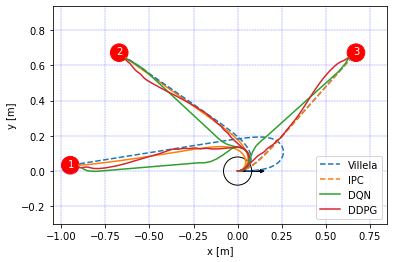

In [22]:
def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)

def set_ymargin(ax, up=0.0, down=0.3):
    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    up = lim[0] - delta*up
    down = lim[1] + delta*down
    ax.set_ylim(up, down)
    
fig, ax = plt.subplots(figsize=(6,4))

x = math.cos(math.radians(178))*0.95
y = math.sin(math.radians(178))*0.95
circle = plt.Circle((x,y), .05, color='r')
ax.text(x-0.015,y-0.01, '1', color='white')
circle2 = plt.Circle((0,0), 0.08, color='k', fill=False)
x = math.cos(math.radians(135))*0.95
y = math.sin(math.radians(135))*0.95
circle3 = plt.Circle((x,y), .05, color='r')
ax.text(x-0.015,y-0.01, '2', color='white')
x = math.cos(math.radians(45))*0.95
y = math.sin(math.radians(45))*0.95

circle4 = plt.Circle((x,y), .05, color='r')
ax.text(x-0.015,y-0.01, '3', color='white')
ax.arrow(0, 0, 0.13, 0, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.add_artist(circle)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
ax.plot(x1,y1, color='tab:orange')
ax.plot(x2,y2, color='tab:orange')
ax.plot(x3,y3, '--', color='tab:blue')
ax.plot(x4,y4, '--', color='tab:blue')
ax.plot(x6,y6, color='tab:green')
ax.plot(x5,y5, color='tab:green')
ax.plot(x8,y8, color='tab:red')
ax.plot(x7,y7, color='tab:red')

ax.plot(x10,y10, '--', label='Villela', color='tab:blue')
ax.plot(x9,y9, '--', label='IPC', color='tab:orange')
ax.plot(x11,y11, label='DQN', color='tab:green')
ax.plot(x12,y12, label='DDPG', color='tab:red')

ax.legend(loc='lower right')
ax.axis('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.grid(color='b', ls = '-.', lw = 0.25)
#set_xmargin(ax, left=0.08, right=0.06)
#set_ymargin(ax, up=0.2, down=0)
ax.set_xlim(-1.05, 0.85)
fig.savefig('Trajectories_all.svg', format='svg', dpi=1200)
#fig.show()

## Indices de Rendimiento

![](Performance_index.png)

In [15]:
# Datos paper "Simulation and Experimental Results of a New control..."

Villela_Paper = [30.77, 28.87, 299.35, 351.46]
IPC_Paper = [22.18, 23.28, 192.94, 255.00]

In [16]:
IR_ipc_178 = indices_rendimiento(IPC_178)
IR_ipc_135 = indices_rendimiento(IPC_135)
IR_dqn_178 = indices_rendimiento(DQN_178)
IR_dqn_135 = indices_rendimiento(DQN_135)
IR_ddpg_178 = indices_rendimiento(ddpg_178)
IR_ddpg_135 = indices_rendimiento(ddpg_135)
IR_villela_178 = indices_rendimiento(Villela_178)
IR_villela_135 = indices_rendimiento(Villela_135)
IR_ipc_90 = indices_rendimiento(IPC_90)
IR_dqn_90 = indices_rendimiento(DQN_90)
IR_ddpg_90 = indices_rendimiento(ddpg_90)
IR_villela_90 = indices_rendimiento(Villela_90)


In [17]:
from tabulate import tabulate
Index = ['ISE','IAE','ITSE','IATE']
PerformanceIndex_178 = {'Index':Index,
                    'Villela':IR_villela_178,
                    'IPC': IR_ipc_178,
                    'DQN': IR_dqn_178,
                    'DDPG' : IR_ddpg_178}

print('Experimental Data 178°')
print('')
print(tabulate(PerformanceIndex_178, headers='keys'))
print('')

PerformanceIndex_135 = {'Index':Index,
                    'Villela':IR_villela_135,
                    'IPC': IR_ipc_135,
                    'DQN': IR_dqn_135,
                    'DDPG' : IR_ddpg_135}

print('Experimental Data 135°')
print('')
print(tabulate(PerformanceIndex_135, headers='keys'))
print('')

PerformanceIndex_90 = {'Index':Index,
                    'Villela':IR_villela_90,
                    'IPC': IR_ipc_90,
                    'DQN': IR_dqn_90,
                    'DDPG' : IR_ddpg_90}

print('Experimental Data 90°')
print('')
print(tabulate(PerformanceIndex_90, headers='keys'))
print('')

Experimental Data 178°

Index      Villela       IPC       DQN      DDPG
-------  ---------  --------  --------  --------
ISE        22.6532   16.5452   13.6689   13.3631
IAE        20.8112   13.0346   10.3243   10.0221
ITSE      253.378   156.313   110.311   106.113
IATE      192.314   100.631    65.1074   61.6821

Experimental Data 135°

Index      Villela       IPC       DQN      DDPG
-------  ---------  --------  --------  --------
ISE       11.6873   11.543    11.4772   11.2921
IAE        8.31947   8.15961   8.08645   7.91108
ITSE      85.3928   83.8793   83.1807   80.9612
IATE      46.7086   45.5759   44.9415   43.3184

Experimental Data 90°

Index      Villela       IPC       DQN      DDPG
-------  ---------  --------  --------  --------
ISE        9.20791   9.22027   9.32935   9.16978
IAE        5.92166   5.9332    6.02107   5.85948
ITSE      58.6016   58.724    59.945    58.4905
IATE      28.4298   28.5167   29.2248   28.134



In [18]:
Index = []

for i in range(4):
    Villela = (IR_villela_90[i] + IR_villela_135[i] + IR_villela_178[i])/3
    IPC = (IR_ipc_90[i] + IR_ipc_135[i] + IR_ipc_178[i])/3
    DQN = (IR_dqn_90[i] + IR_dqn_135[i] + IR_dqn_178[i])/3
    DDPG = (IR_ddpg_90[i] + IR_ddpg_135[i] + IR_ddpg_178[i])/3
    
    Index.append([Villela, IPC, DQN, DDPG])
print(Index)
Index =np.transpose(Index)


[[14.516125236974753, 12.436146066331396, 11.491823297335182, 11.274982849044454], [11.684122677966338, 9.042456337908547, 8.143924914619214, 7.930899267725411], [132.45740917817182, 99.63863847568034, 84.47901917557799, 81.85476158172578], [89.15083788495372, 58.24104374717015, 46.42456337502686, 44.37817233567237]]


In [19]:
def aproximar(algoritmo):
    for i in range(len(algoritmo)):
        algoritmo[i] = round(algoritmo[i], 2)
    return algoritmo

Index[0] = aproximar(Index[0])
Index[1] = aproximar(Index[1])
Index[2] = aproximar(Index[2])
Index[3] = aproximar(Index[3])

In [20]:
keys = ['ISE','IAE','ITSE','IATE']

PerformanceIndexProm = {'Index':keys,
                    'Villela':Index[0],
                    'IPC': Index[1],
                    'DQN': Index[2],
                    'DDPG' : Index[3]}

print('Experimental Data promedio')
print('')
print(tabulate(PerformanceIndexProm, headers='keys'))
print('')

Experimental Data promedio

Index      Villela    IPC    DQN    DDPG
-------  ---------  -----  -----  ------
ISE          14.52  12.44  11.49   11.27
IAE          11.68   9.04   8.14    7.93
ITSE        132.46  99.64  84.48   81.85
IATE         89.15  58.24  46.42   44.38



In [21]:
tiempo_IPC_178 = (len(IPC_178['paso'])*0.05)
tiempo_IPC_135 = (len(IPC_135['paso'])*0.05)
tiempo_IPC_90 = (len(IPC_90['paso'])*0.05)

Tiempo_IPC = (tiempo_IPC_90+tiempo_IPC_135+tiempo_IPC_178)/3
#print('Tiempo promedio IPC:', Tiempo_IPC)

tiempo_Villela_178 = (len(Villela_178['paso'])*0.05)
tiempo_Villela_135 = (len(Villela_135['paso'])*0.05)
tiempo_Villela_90 = (len(Villela_90['paso'])*0.05)

Tiempo_Villela = (tiempo_Villela_90+tiempo_Villela_135+tiempo_Villela_178)/3
#print('Tiempo promedio Villela:', Tiempo_Villela)

tiempo_DQN_178 = (len(DQN_178['paso'])*0.05)
tiempo_DQN_135 = (len(DQN_135['paso'])*0.05)
tiempo_DQN_90 = (len(DQN_90['paso'])*0.05)

Tiempo_DQN = (tiempo_DQN_90+tiempo_DQN_135+tiempo_DQN_178)/3
#print('Tiempo promedio DQN:', Tiempo_DQN)

tiempo_ddpg_178 = (len(ddpg_178['paso'])*0.05)
tiempo_ddpg_135 = (len(ddpg_135['paso'])*0.05)
tiempo_ddpg_90 = (len(ddpg_90['paso'])*0.05)

Tiempo_ddpg = (tiempo_ddpg_90+tiempo_ddpg_135+tiempo_ddpg_178)/3
#print('Tiempo promedio ddpg:', Tiempo_ddpg)

Algoritmos = ['Villela', 'IPC', 'DQN', 'DDPG']

TP_1 = [tiempo_Villela_178, tiempo_IPC_178, tiempo_DQN_178, tiempo_ddpg_178]
TP_2 = [tiempo_Villela_135, tiempo_IPC_135, tiempo_DQN_135, tiempo_ddpg_135]
TP_3 = [tiempo_Villela_90, tiempo_IPC_90, tiempo_DQN_90, tiempo_ddpg_90]
Prom = [Tiempo_Villela, Tiempo_IPC, Tiempo_DQN, Tiempo_ddpg]

Tiempos = {'algoritmos' : Algoritmos,
           'TP_1' : TP_1,
           'TP_2' : TP_2,
           'TP_3' : TP_3,
           'Promedio' : Prom}

print('Tiempos de llegada a los TPs promedio')
print('')
print(tabulate(Tiempos, headers='keys'))
print('')

Tiempos de llegada a los TPs promedio

algoritmos      TP_1    TP_2    TP_3    Promedio
------------  ------  ------  ------  ----------
Villela        30.45    20.8   18.25     23.1667
IPC            25.8     20.7   18.25     21.5833
DQN            22.5     20.7   18.45     20.55
DDPG           22.55    20.5   18.3      20.45

